In [107]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [108]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from converter import pdbgraph
converter = pdbgraph.PDB2PyG()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [109]:
modelname = 'large5_geo_graph_mf_contactdecoder'

with open( modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

encoder.eval()
decoder.eval()	
encoder.to(device)
decoder.to(device)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-6): 7 x HeteroConv(num_relations=2)
  )
  (norms): ModuleList(
    (0-6): 7 x LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((700,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=700, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate='none')
    (5): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  )
  (aadecoder): Sequential(
    (0): Linear(in_features=420, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3)

In [110]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
11it [00:00, 16.50it/s]


In [111]:
encoded_fasta =  modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

179it [00:00, 148846.24it/s]


In [112]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [113]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A7S2SRA2  ø'ýø$...   
H8X1F7      (($'÷$(÷$ø$...   
A0A7C1HX16  ($'\t\'ø!ý...   
A0A2H6KBL1  $$$'$$'ø((...   
A0A378LGA6  (((((ø$'(\tý...   
A0A2G9IAV9  ÷$$÷÷'($$$÷...   
A0A142Z0W3  ÷$'$$ø$÷$ý(...   
A0A383VZ65  '÷÷$÷'$($÷÷$...   
A0A7J6FVH6  ($(($$($÷$'...   
A0A1J4KD37  !!$$\t'$'ø...   

                                                          ord  \
protid                                                          
A0A7S2SRA2  [22, 22, 17, 19, 11, 21, 23, 25, 34, 17, 39, 2...   
H8X1F7      [5, 7, 40, 16, 40, 5, 20, 16, 1, 20, 16,

In [114]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A7S2SRA2


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

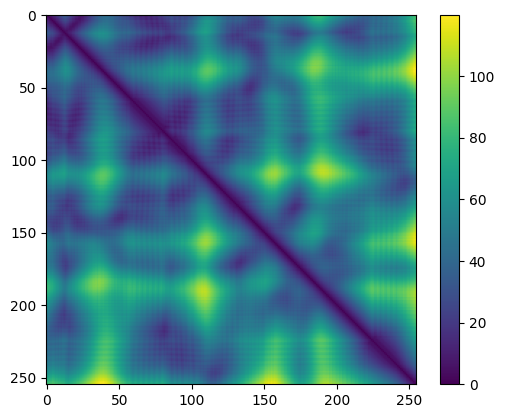

255
torch.Size([255, 20])
HeteroData(
  res={
    x=[255, 20],
    batch=[255],
  },
  positions={ x=[255, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 254] },
  (res, backbone_rev, res)={ edge_index=[2, 254] },
  (godnode4decoder, informs, res)={ edge_index=[2, 255] },
  (res, informs, godnode4decoder)={ edge_index=[2, 255] },
  (res, informs, godnode)={ edge_index=[2, 255] }
)
torch.Size([65025])
tensor([[ -9.3762, -11.5556, -11.2427,  ..., -11.2363,  -8.9017,  -7.3885],
        [ -5.7704, -13.4071, -12.2985,  ..., -12.9469, -13.6616,  -6.6187],
        [-10.5217, -14.2129, -10.1479,  ..., -14.0006, -15.6399, -11.5987],
        ...,
        [-10.9251, -14.3452, -15.2013,  ..., -13.6463, -14.2059,  -7.3527],
        [-10.3706, -15.0090, -14.4940,  ..., -13.5921, -13.9821,  -7.4642],
        [-13.1584, -11.3986, -10.7396,  ...,  -7.8377,  -3.7908, -10.9205]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.000

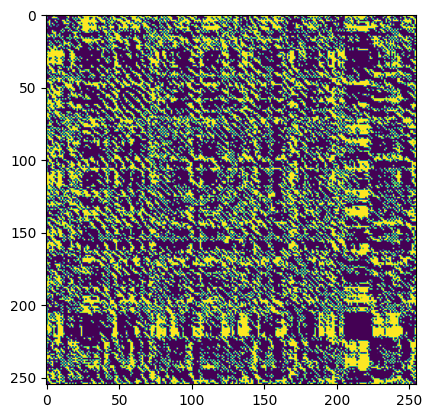

torch.Size([255, 255])
(255, 255)


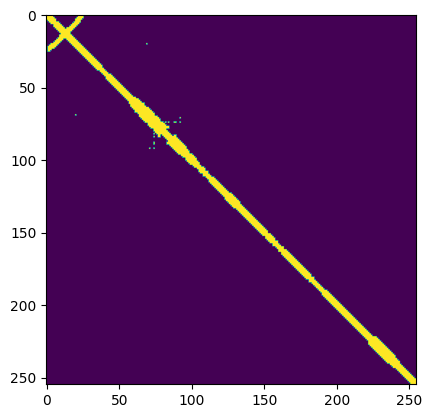

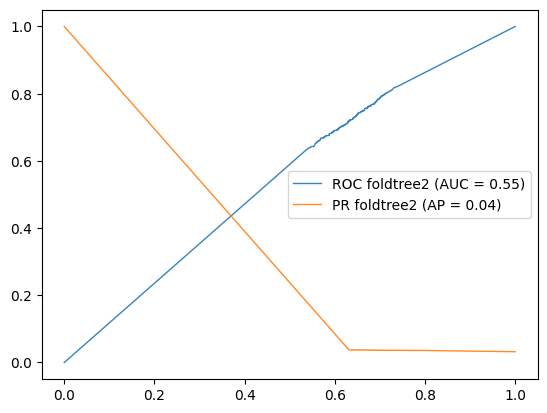

H8X1F7


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

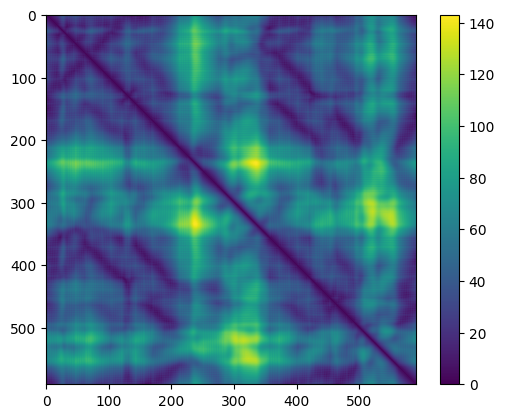

580
torch.Size([580, 20])
HeteroData(
  res={
    x=[580, 20],
    batch=[580],
  },
  positions={ x=[580, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 579] },
  (res, backbone_rev, res)={ edge_index=[2, 579] },
  (godnode4decoder, informs, res)={ edge_index=[2, 580] },
  (res, informs, godnode4decoder)={ edge_index=[2, 580] },
  (res, informs, godnode)={ edge_index=[2, 580] }
)
torch.Size([336400])
tensor([[-12.9899, -15.3852, -11.6600,  ..., -14.6514, -15.8900, -13.5687],
        [ -4.2298,  -8.7731,  -6.6572,  ...,  -9.8939,  -9.6542,  -5.9814],
        [ -5.0027, -13.4533, -12.5098,  ..., -13.3770, -13.7112,  -6.3409],
        ...,
        [-10.4841, -15.1267, -14.7239,  ..., -13.8157, -14.0456,  -7.2671],
        [ -8.8885, -13.0907, -13.8958,  ..., -13.4908, -15.1299, -10.0197],
        [ -6.8570, -14.9670, -12.5179,  ..., -12.5121, -16.4782,  -5.9993]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.00

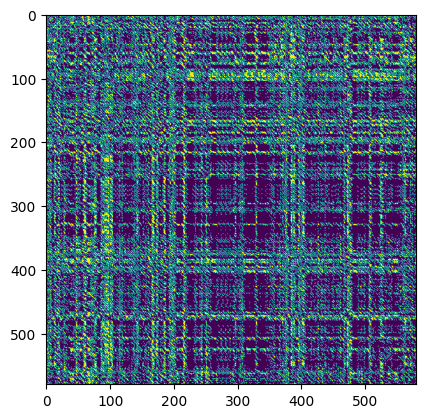

torch.Size([580, 580])
(591, 591)


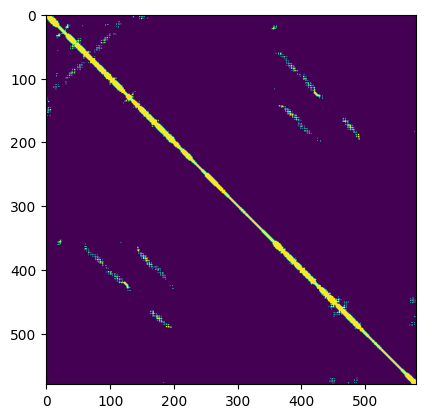

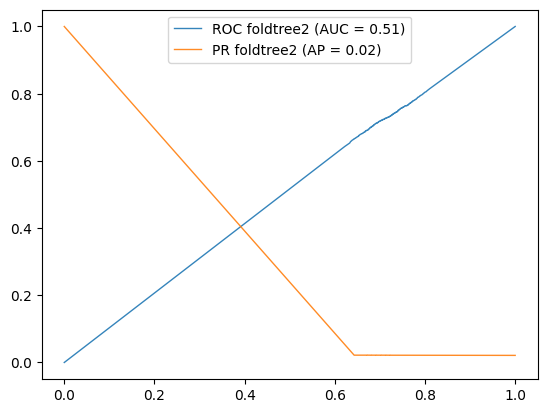

A0A7C1HX16


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

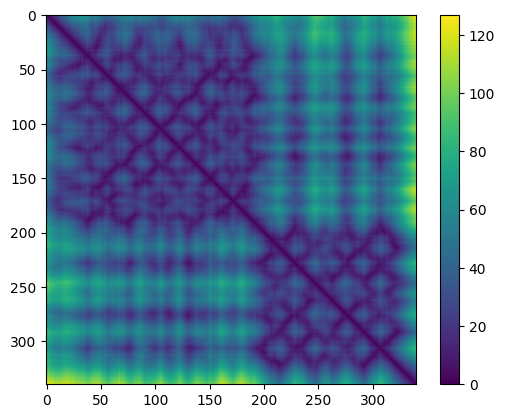

318
torch.Size([318, 20])
HeteroData(
  res={
    x=[318, 20],
    batch=[318],
  },
  positions={ x=[318, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 317] },
  (res, backbone_rev, res)={ edge_index=[2, 317] },
  (godnode4decoder, informs, res)={ edge_index=[2, 318] },
  (res, informs, godnode4decoder)={ edge_index=[2, 318] },
  (res, informs, godnode)={ edge_index=[2, 318] }
)
torch.Size([101124])
tensor([[-8.6067e+00, -1.2548e+01, -1.2369e+01,  ..., -1.3404e+01,
         -1.5646e+01, -9.0722e+00],
        [-9.5886e+00, -1.9620e-03, -7.4692e+00,  ..., -9.4175e+00,
         -7.2414e+00, -1.2042e+01],
        [-1.0472e+01, -1.5118e+01, -1.4835e+01,  ..., -1.3819e+01,
         -1.4606e+01, -6.2030e+00],
        ...,
        [-1.3654e+01, -1.0165e+01, -1.1688e+01,  ..., -2.4156e+00,
         -6.1909e+00, -1.0232e+01],
        [-7.6614e+00, -1.1472e+01, -9.2960e+00,  ..., -1.1156e+01,
         -1.0894e+01, -7.0266e+00],
        [-

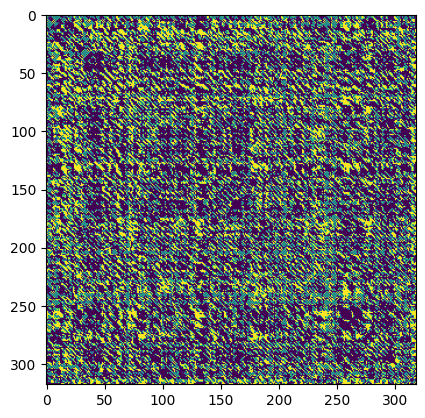

torch.Size([318, 318])
(340, 340)


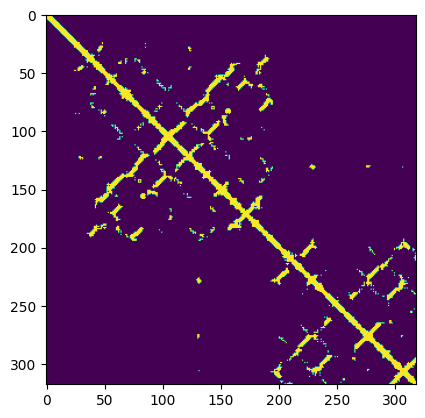

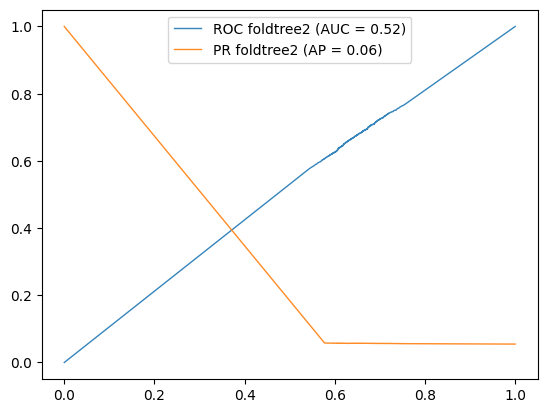

A0A2H6KBL1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

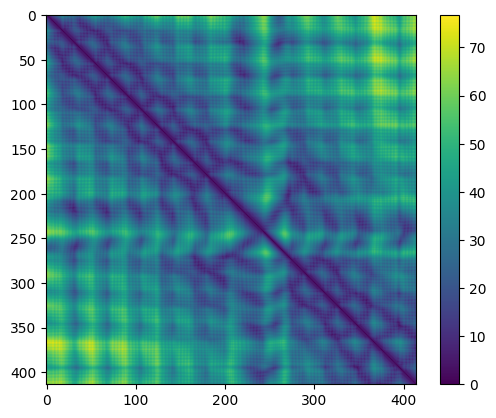

386
torch.Size([386, 20])
HeteroData(
  res={
    x=[386, 20],
    batch=[386],
  },
  positions={ x=[386, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 385] },
  (res, backbone_rev, res)={ edge_index=[2, 385] },
  (godnode4decoder, informs, res)={ edge_index=[2, 386] },
  (res, informs, godnode4decoder)={ edge_index=[2, 386] },
  (res, informs, godnode)={ edge_index=[2, 386] }
)
torch.Size([148996])
tensor([[ -7.6112, -13.4623, -12.0716,  ..., -11.6878, -15.5216,  -4.5440],
        [-11.0751, -14.8248, -13.4267,  ..., -13.8899, -14.7739,  -7.4863],
        [ -7.5883,  -0.0200,  -6.4753,  ..., -10.0833,  -7.5690, -10.5677],
        ...,
        [ -1.9433, -13.1711, -14.2719,  ..., -14.2197, -13.8224,  -0.1667],
        [ -5.7078, -10.2949, -10.4300,  ..., -11.2425, -12.5484,  -5.2289],
        [ -6.3588, -13.9653, -14.3605,  ..., -13.2734, -15.1491,  -0.4657]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.00

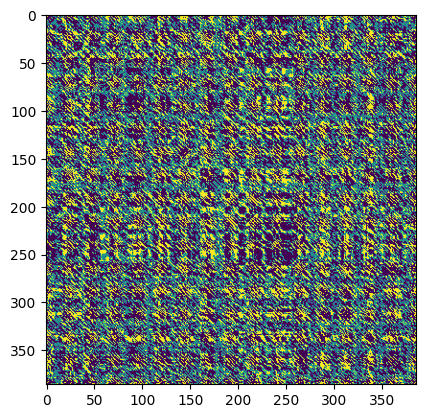

torch.Size([386, 386])
(414, 414)


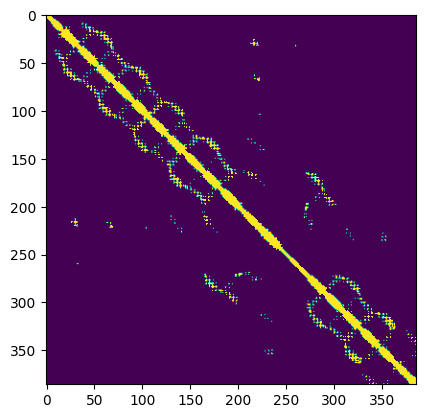

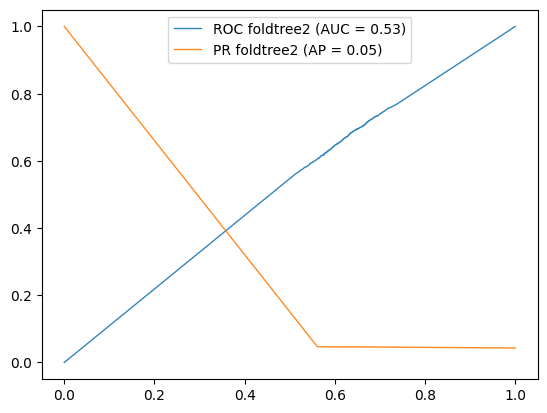

A0A378LGA6


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

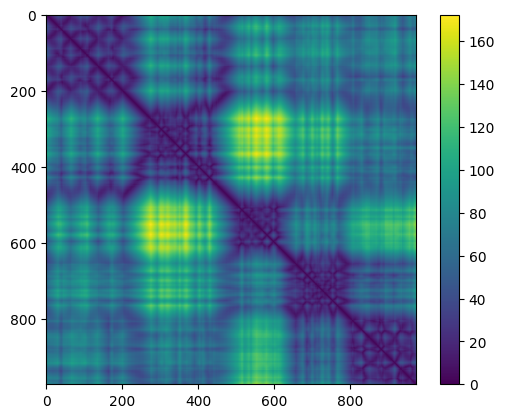

898
torch.Size([898, 20])
HeteroData(
  res={
    x=[898, 20],
    batch=[898],
  },
  positions={ x=[898, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 897] },
  (res, backbone_rev, res)={ edge_index=[2, 897] },
  (godnode4decoder, informs, res)={ edge_index=[2, 898] },
  (res, informs, godnode4decoder)={ edge_index=[2, 898] },
  (res, informs, godnode)={ edge_index=[2, 898] }
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.10 GiB. GPU 0 has a total capacity of 5.79 GiB of which 496.69 MiB is free. Process 2278329 has 594.00 MiB memory in use. Including non-PyTorch memory, this process has 4.70 GiB memory in use. Of the allocated memory 3.14 GiB is allocated by PyTorch, and 1.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [115]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric
import losses

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles , r2,t2,angles2= decoder( data , allpairs ) 

	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [73]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [83]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined